# Batch Normalization

## Terminology

Term | Definition
------| ---------
Internal covariate shift | change in distribution of network activations due to the change in network parameters during training.
|

### What is the Problem Batch Normalization is trying to Solve?

The input to each layer is affected by parameters of all preceeding layer.  Hence this produces an "amplification" effect.



#### Effect of a large x in activation functions

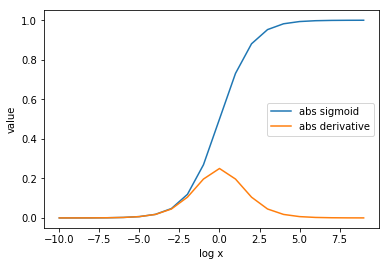

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

eps = 1e-10
def sigmoid(x):
    return 1./(1 + np.exp(-1*x))

def d_sigmoid(x):
    return sigmoid(x)*(1 - sigmoid(x))


x = np.arange(-10, 10)
y_sigmoid = list(map(abs, map(sigmoid, x)))
yd_sigmoid = list(map(abs,map(d_sigmoid, x)))


plt.plot(x, y_sigmoid)
plt.plot(x, yd_sigmoid)
plt.legend(['abs sigmoid', 'abs derivative'], loc='center right')
plt.xlabel('log x')
plt.ylabel('value')
plt.show()

Note as x increases, the derivative tends to zero.  Hence, the resulting gradient will be extremely small and that would affect the rate of convergence.  This is known as *vanishing gradients*.  Moreover, the large x value tends to *saturate* the activation function (pushing it to an asymptotic value, which in turns result in the vanishing gradient).  This phenonmon is why we use ReLU as an activation function.

## Benefits of Normalizing Input

1. Reduces the effect of *internal convariate shift* (which can amplifiy *vanishing gradients* down the network), hence increase the training speed
2. Reduce the dependence of gradients on the scale of the parameters or of their initial values
3. Regularizes the models f

**Great**, why don't we just normalize all the input values then?  

#### First question:  where do we put the normalization function?

Let $x = u + b$ where u is the input value and b is the bias.  If we were to normalize x after applying the bias, i.e $\hat{x} = x - \mathbb{E}[x]$, which essentially treats b as part of the data x.  Then we will have no control over the growth of the bias $b$.

Suppose we are updating $b$:  $b \leftarrow b + \Delta b$.

When updating the normalized value $\hat{x} \leftarrow \hat{x} + \Delta \hat{x}$

$\hat{x} = u + b - \mathbb{E}[u+b] = u + b + \Delta b - \Delta b - \mathbb{E}[u+b] =  u + b + \Delta b  - \mathbb{E}[u+b+ \Delta b] = \hat{x} + \Delta \hat{x}$.

Notice updating b have no effect on the normalized x and in turn no effect on the loss function.  Essentially, b will explode when normalization is computed outside of gradient descent.  


#### So we established normalization parameters must be part of gradient descent.  I.e. We must take derivative with repect to norm.

Let $$\hat{x} = Norm(x, \mathcal{X})$$

**Question:  Why does these Jacobians depend on the covariance matrix of X?** (Math Exercise)

$$ \partial Norm(x, \mathcal{X}) / \partial x $$

and 

$$ \partial Norm(x, \mathcal{X}) / \partial \mathcal{X} $$

Just by pure intution, you are taking the derivative with of a r.v. vector with respect to another r.v. vector.  What do you expect to happen?




Either the case, taking derivative with respect to the norm can result in large computational complexity.  So we need to find a more heuristic way to normalize the inputs:  **Batch Normalization** 

### What is the strategy behind Batch Normalization?



1. We will normalize each layer individually (independently)
2. What happens if you input a normal variable in an sigmoid function?

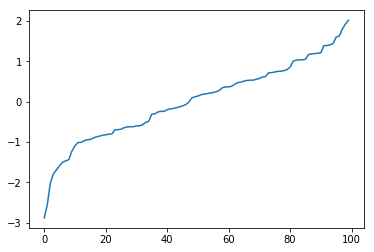

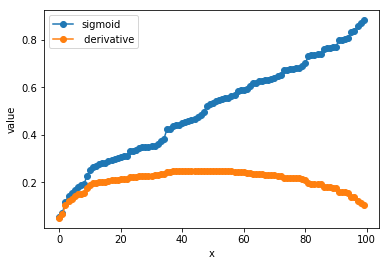

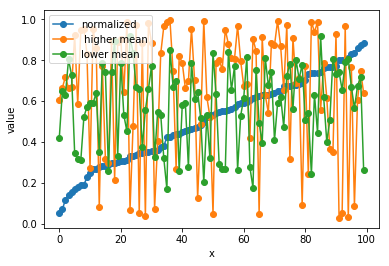

In [16]:
x = np.random.normal(0, 1, 100) # normalized input x
x.sort()
y_sigmoid = list( map(sigmoid, x))
yd_sigmoid = list(map(d_sigmoid, x))

plt.plot(x)
plt.show()
plt.plot(y_sigmoid, '-o')
plt.plot(yd_sigmoid, '-o')
plt.legend(['sigmoid', ' derivative'], loc='upper left')
plt.xlabel('x')
plt.ylabel('value')
plt.show()

# Other distributions
x1 = np.random.normal(1, 2, 100)
y1_sigmoid = list( map(sigmoid, x1))

x2 = np.random.normal(0.25, 0.9, 100)
y2_sigmoid = list( map(sigmoid, x2))

plt.plot(y_sigmoid, '-o')
plt.plot(y1_sigmoid, '-o')
plt.plot(y2_sigmoid, '-o')
plt.legend(['normalized', ' higher mean', "lower mean"], loc='upper left')
plt.xlabel('x')
plt.ylabel('value')
plt.show()

The paper indicated that just having a normalized input will be constrained by sigmoid to "linear regime of nonlinearlity".  I suppose what this means is after a sigmoid function, the above normalized blue line have a almost linear trend.

This is why we are introducing some parameter to transform the normalized value.  i.e.

$$y^{(k)} = \gamma^{(k)} \hat{x}^{(k)} + \beta^{(k)} $$


### Batchnorm algorithm

![](images/batchnorm.png)

![](images/batchnorm_alg.png)

In [ ]:
def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Forward pass for batch normalization.

    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keepad an exponentially decaying running mean of the mean
    and variance of each feature, and these averages are used to normalize data
    at test-time.

    At each timestepad we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7 implementation
    of batch normalization also uses running averages.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
    - mode: 'train' or 'test'; required
    - eps: Constant for numeric stability
    - momentum: Constant for running mean / variance.
    - running_mean: Array of shape (D,) giving running mean of features
    - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':

        mu = np.mean(x, axis=0) # mu -  1 X D
        var = np.var(x, axis=0) # mu - 1 X D

        svar = np.sqrt(var + eps) # (var + eps)^{1/2}
        xmu = x - mu
        xhat = xmu/(svar) # x^

        # Shift
        out = gamma*xhat + beta

    running_mean = momentum * running_mean + (1 - momentum) * mu
    running_var = momentum * running_var + (1 - momentum) * var
    cache = (xhat,svar,var,eps,gamma,xmu)

    elif mode == 'test':

        x = (x - running_mean)/(np.sqrt(running_var + eps))
        out = gamma*x + beta


    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache


def batchnorm_backward(dout, cache):
    """
    Backward pass for batch normalization.

    For this implementation, you should write out a computation graph for
    batch normalization on paper and propagate gradients backward through
    intermediate nodes.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    N, D = dout.shape
    dx, dgamma, dbeta = None, None, None
    xhat,svar,var,eps,gamma,xmu = cache

    db = np.sum(dout, axis=0)
    # dgx = dout

    dg = np.sum(dout*xhat, axis=0)
    dxhat = dout*gamma

    dinv = np.sum(dxhat*xmu, axis=0)
    dsvar = -1./(svar**2)*dinv
    dvar = 0.5*1./np.sqrt(var+eps)*dsvar
    dsq = 1./N*np.ones((N,D))*dvar
    dxmu = dxhat/svar + 2*xmu*dsq
    dmu = -1 * np.sum(dxmu, axis=0)
    dx = dxmu + 1. /N * np.ones((N,D)) * dmu


    return dx, dg, db


### Why do we use moving averages instead in testing time?

The purpose of moving average and variance estimate is to estimate the population statistics.  

### Normalizing Convolutional Networks

Instead of transforming input of every layer x into BN(x), convolutional networks will normalize by feature map.  Per minibatch of size m and feature map of size (p,q), corresponding value to be normalized is (m, pq).

Note:  This is a little unclear.

 Given an input $X \in (N, C, H, W)$ and a convolutional layer $(F, C, HH, WW)$, with the resulting output 
 
 $$(N, F, H', W)$$, 
 
 which is normalized?
 1. X
 2. The convolutional layer
 3. Output
 
How does normalization preserve convolution?

![](images/spatial_batchnorm.png)

#### Further question:  How does BN affect gradient propogation?

### Architecture Change that utilizes BN effectively

1. Increase Learning Rate
2. Remove Dropout
3. Reduce L_2 weight regularization
4. Accelerate the learning rate decay
5. Remove Local Response Normalization 
6. Shuffle training examples more throughly
7. Reduce photometric distortions